(427, 640, 3)


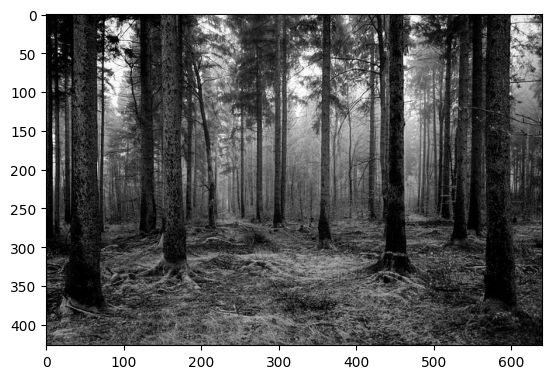

In [2]:
from skimage import io, img_as_float, img_as_ubyte
from skimage.metrics import structural_similarity as ssim
from scipy import signal
from math import log10
import matplotlib.pyplot as plt
import numpy as np
import json 


wood_img = io.imread("wood.jpg")
print(wood_img.shape)

R_1 = wood_img[:, :, 0] 
G_1 = wood_img[:, :, 1]
B_1 = wood_img[:, :, 2]

#formula for converting colour(RGB) to Gray Image scale Image
Y_wood = (0.299 * np.array(R_1)) + (0.587 * np.array(G_1)) + (0.114 * np.array(B_1)) 

plt.imshow(Y_wood , cmap = "gray")
# print(Y_wood.shape)
# pattern for aproximation and exact adder
energy_consumption_list = []
energy_consumption_list.append([2068.7, 1962.8, 1853.7, 1797.8, 1982.9, 1893.6, 1882, 1811.2]) # exact adder
energy_consumption_list.append([696.69, 661.61, 641.48, 611.95, 642.26, 612.56, 581.57, 568.23]) # own Aprox
energy_consumption_list.append([722.64, 801.437,667.417, 686.277, 759.353, 742.095, 695.799, 720.61]) # SIAFA 1
energy_consumption_list.append([1011.046, 955.49, 960.609, 946.953, 910.111, 898.936, 936.505, 927.341]) # SIAFA 2
energy_consumption_list.append([722.58, 709.08, 760.5, 744.12, 668.6, 689.24, 698.24, 724.26]) # SIAFA 3
energy_consumption_list.append([722.68, 709.38, 667.2, 687.02, 752.12, 729.72, 701.59, 721.4]) # SIAFA 4
energy_consumption_list.append([772.01, 715.242, 716.736, 693.766, 751.802, 700.172, 688.285, 678.696]) # Serial Aprox
energy_consumption_list.append([696.69, 661.61, 641.48, 611.95, 642.26, 612.56, 581.57, 568.23]) # TODO Semi Serial Aprox data missing
energy_consumption_list.append([696.69, 661.61, 641.48, 611.95, 642.26, 612.56, 581.57, 568.23]) # TODO own 3Memristors


truthTable_s_list = []
truthTable_s_list.append([0, 1, 1, 0, 1, 0, 0, 1]) # exact adder
truthTable_s_list.append([1, 1, 1, 1, 1, 1, 0, 1]) # own Aprox
truthTable_s_list.append([1, 1, 1, 0, 1, 1, 0, 0]) # SIAFA 1
truthTable_s_list.append([1, 1, 1, 0, 1, 0, 0, 0]) # SIAFA 2
truthTable_s_list.append([1, 1, 1, 1, 1, 0, 0, 0]) # SIAFA 3
truthTable_s_list.append([1, 1, 1, 0, 1, 0, 1, 0]) # SIAFA 4
truthTable_s_list.append([1, 1, 1, 0, 1, 1, 0, 0]) # Serial Aprox
truthTable_s_list.append([1, 1, 1, 0, 0, 0, 0, 0]) # Semi Serial Aprox
truthTable_s_list.append([1, 1, 1, 0, 1, 1, 1, 1]) # own 3Memristors


truthTable_c_list = []
truthTable_c_list.append([0, 0, 0, 1, 0, 1, 1, 1]) # exact adder
truthTable_c_list.append([0, 1, 0, 1, 0, 1, 1, 1]) # own Aprox
truthTable_c_list.append([0, 0, 0, 1, 0, 0, 1, 1]) # SIAFA 1
truthTable_c_list.append([0, 1, 0, 1, 0, 1, 1, 1]) # SIAFA 2
truthTable_c_list.append([0, 0, 0, 0, 0, 1, 1, 1]) # SIAFA 3
truthTable_c_list.append([0, 0, 0, 1, 0, 1, 0, 1]) # SIAFA 4
truthTable_c_list.append([0, 0, 0, 1, 0, 0, 1, 1]) # Serial Aprox
truthTable_c_list.append([0, 0, 0, 1, 1, 1, 1, 1]) # Semi Serial Aprox
truthTable_c_list.append([0, 1, 0, 1, 0, 1, 0, 1]) # own 3Memristors

nameApprox_list = []
nameApprox_list.append("exact")
nameApprox_list.append("own_Aprox")
nameApprox_list.append("SIAFA 1")
nameApprox_list.append("SIAFA 2")
nameApprox_list.append("SIAFA 3")
nameApprox_list.append("SIAFA 4")
nameApprox_list.append("Serial Aprox")
nameApprox_list.append("Semi Serial Aprox")
nameApprox_list.append("own_3Memristors")

# write data to json file 
# Create a dictionary to hold the parsed data
parsed_data = {}
empty_list = [0,0,0,0,0,0,0,0,0]

# Populate the dictionary
for i, name in enumerate(nameApprox_list):
    parsed_data[name] = {"s": truthTable_s_list[i], "c": truthTable_c_list[i], "energy": energy_consumption_list[i], "ssi": empty_list, "psnr": empty_list, "energy_con": empty_list}

json_file_path = 'data.json'

# Write the data to the JSON file
with open(json_file_path, 'w') as json_file:
    json.dump(parsed_data, json_file, indent=4)


In [55]:
from bitstring import Bits
import math

# Load the data from the JSON file into a dictionary
with open(json_file_path, 'r') as json_file:
    loaded_dict = json.load(json_file)

kernel_list = []
blurrKernel = np.array([[1,1,1],[1,1,1],[1,1,1]])
edgeDetectionKernel = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
kernel_list.append(blurrKernel)
kernel_list.append(edgeDetectionKernel)

kernelname_list = []
kernelname_list.append("blurr")
kernelname_list.append("edge_detection")    

# assign the correct values for carry sum and energy acccording to choosen Algorithm

def Adder(a, b, c, approxAlgo = 'exact'):
    if a==0 and b==0 and c==0:
        s = loaded_dict[approxAlgo]["s"][0]
        c_out = loaded_dict[approxAlgo]["c"][0]
        energy_consumption = loaded_dict[approxAlgo]["energy"][0]
    elif a==0 and b==0 and c==1:
        s = loaded_dict[approxAlgo]["s"][1]
        c_out = loaded_dict[approxAlgo]["c"][1]
        energy_consumption = loaded_dict[approxAlgo]["energy"][1]
    elif a==0 and b==1 and c==0:
        s = loaded_dict[approxAlgo]["s"][2]
        c_out = loaded_dict[approxAlgo]["c"][2]
        energy_consumption = loaded_dict[approxAlgo]["energy"][2]
    elif a==0 and b==1 and c==1:
        s = loaded_dict[approxAlgo]["s"][3]
        c_out = loaded_dict[approxAlgo]["c"][3]
        energy_consumption = loaded_dict[approxAlgo]["energy"][3]
    elif a==1 and b==0 and c==0:
        s = loaded_dict[approxAlgo]["s"][4]
        c_out = loaded_dict[approxAlgo]["c"][4]
        energy_consumption = loaded_dict[approxAlgo]["energy"][4]
    elif a==1 and b==0 and c==1:
        s = loaded_dict[approxAlgo]["s"][5]
        c_out = loaded_dict[approxAlgo]["c"][5]
        energy_consumption = loaded_dict[approxAlgo]["energy"][5]
    elif a==1 and b==1 and c==0:
        s = loaded_dict[approxAlgo]["s"][6]
        c_out = loaded_dict[approxAlgo]["c"][6]
        energy_consumption = loaded_dict[approxAlgo]["energy"][6]
    elif a==1 and b==1 and c==1:
        s = loaded_dict[approxAlgo]["s"][7]
        c_out = loaded_dict[approxAlgo]["c"][7]
        energy_consumption = loaded_dict[approxAlgo]["energy"][7]
    return s, c_out, energy_consumption

def My_Multiplier(a,b, approxAlgo, approxBit, blurrFlag=False):
    energy = 0
    if a > b:
        res = a
        multiplier = a
        multcount = b
    else:
        res = b
        multiplier = b
        multcount = a
    
    for i in range(1, multcount):
        res, e  = MyNbitAdder(res, multiplier, approxAlgo, approxBit)
        energy += e
    # if blurrFlag:
    #     res = res >> 3
    return res, energy


def My_Mult(a, b, approxAlgo, approxBit):
    '''go throw every pixel in 3x3 matrix'''
    energy = 0
    res = np.zeros((a.shape[0],a.shape[1]))
    for k in range(a.shape[0]):
        for l in range(a.shape[1]):
            res[k,l], e = My_Multiplier(int(a[k,l]), int(b[k,l]), approxAlgo, approxBit)
            energy += e
    return res, energy

# Convolution
def MyconvLUT(a, b, aproxAlgo, aproxBit, demoDataFlag=False):
    if demoDataFlag:
        return a, 1000000
    a = a.astype(int)
    b = b.astype(int)
    a_shape = np.shape(a)
    b_shape = np.shape(b)
    res_shape1 = np.abs(a_shape[0] - b_shape[0]) + 1
    res_shape2 = np.abs(a_shape[1] - b_shape[1]) + 1

    res = np.zeros((res_shape1, res_shape2))
    energy = 0
    for i in range(res_shape1):
        for j in range(res_shape2):
            resmatrix, energy = My_Mult(np.flip(b), a[i:i + b_shape[0], j:j + b_shape[1]], aproxAlgo, aproxBit)                   
            res[i, j], e  = MySum(resmatrix, energy, aproxAlgo, aproxBit)
            energy += e
    return res, energy

def MySum(matrix, energy, approxAlgo, approxBit):
    res = 0
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            res, e = MyNbitAdder(res, int(matrix[i,j]), approxAlgo, approxBit)
        energy += e
    return res, energy

#In 8 bit adder, lower 3 bits are implemented with approximate adder and rest of the with exact adder
def MyNbitAdder(a, b, Algo, Bit):
    try:
        minusABFlag = False 
        #convert to binary and cut off the first two indices (they dont belong to the number but indicate that it is binary)

        if a >= 0 and b >= 0:    
            a_bin = bin(a)[2:]
            b_bin = bin(b)[2:]
        elif a < 0 and b >= 0:
            a_bin = decimal2TwoComplement(a)
            b_bin = bin(b)[2:]
        elif a >= 0 and b < 0:
            a_bin = bin(a)[2:]
            b_bin = decimal2TwoComplement(b)
        elif a < 0 and b < 0:
            minusABFlag = True
            a_bin = bin(a)[3:]
            b_bin = bin(b)[3:]
        else:
            print('Error')


        #reverse order of bytes for the adder
        rev_a, rev_b = list(a_bin[::-1]), list(b_bin[::-1])
        
        #We want to make the to bytes to equalt length such that we can add 
        #--> add zeros to the shortest list until it is the same as the longest

        if a >= 0 or minusABFlag: 
            rev_a = rev_a + max(0, len(rev_b)-len(rev_a)) * [0]
        else: 
            rev_a = rev_a + max(0, len(rev_b)-len(rev_a)) * [1]
        
        if b >= 0 or minusABFlag:
            rev_b = rev_b + max(0, len(rev_a)-len(rev_b)) * [0]
        else:
            rev_b = rev_b + max(0, len(rev_a)-len(rev_b)) * [1]
             
        carry_over  = 0
        total_sum   = 0
        
        #############################################
        approx_until = Bit #change this if u want to approximate the first bits by an approximate adder
        #############################################
        sum_list = []
        #we want to do a bitwise addition

        total_energy = 0
        for index, (bit1, bit2) in enumerate(zip(rev_a, rev_b) ):
            if index < approx_until:
                #use approx_adder
                sum_element, carry_over, _energy = Adder(int(bit1), int(bit2), int(carry_over), Algo) 
            else:
                #use exact_adder
                sum_element, carry_over, _energy = Adder(int(bit1), int(bit2), int(carry_over))
            
            sum_list.append(int(sum_element))
            total_energy += _energy
        
        if a+b < 0 and not minusABFlag:
            # sum_list.append(int(carry_over))
            print(sum_list)
            total_sum = twoComplement2Decimal(sum_list)
        elif a+b >= 0 and a >= 0 and b >= 0:
            sum_list.append(int(carry_over))
            print(sum_list)
            total_sum = binary2Decimal(sum_list)
        elif a+b >= 0 and (a < 0 or b < 0):
            # sum_list.append(int(carry_over))
            print(sum_list)
            total_sum = binary2Decimal(sum_list)
        elif minusABFlag:
            sum_list.append(int(carry_over))
            print(sum_list)
            total_sum = binary2Decimal(sum_list)
            total_sum = total_sum * (-1)

        return total_sum, total_energy #total energy in pJ!
    except Exception as e:
        print(f'Error: {e}')
    
def decimal2TwoComplement(num) -> list:
    num_bits = int(math.log2(abs(num))) + 3
    binary = bin(num & (2 ** num_bits - 1))[2:]  # Calculate two's complement
    bitlist = [int(bit) for bit in binary.zfill(num_bits)]
    # print(bitlist)
    return bitlist 

def twoComplement2Decimal(bitlist):
    # Check if the number is negative
    revnum = list(bitlist[::-1])

    # Perform two's complement negation
    flipped_bits = ''
    for bit in revnum:
        if bit == 0:
            flipped_bits = flipped_bits + '1'
        else: 
            flipped_bits = flipped_bits + '0'
    # print(flipped_bits)
    positive_decimal = int(flipped_bits, 2) + 1
    return -positive_decimal

def binary2Decimal(bitlist):
    # Convert the bit list to a string
    revnum = list(bitlist[::-1])
    bitstring = ''
    for bit in revnum:
        if bit == 1:
            bitstring = bitstring + '1'
        else: 
            bitstring = bitstring + '0'
    
    # Convert the bit string to a decimal number
    decimal_number = int(bitstring, 2)
    return decimal_number


## calculate Convolution and write to file system

In [28]:
import os
import json

rows = 12
coll = 8
bit_list = range(0,rows)
algo_list = ["own_Aprox"]

calcAllNewFlag = False 
demoDataFlag = False

add_approx_list = []
total_energy_lsit = []

def checkFilePresent(name):
    if os.path.isfile(f'data/{name}.png'):
        return True
    else: 
        return False
       
# loop throw all Bitpositions 
for indexAlgo, approxAlgo in enumerate(algo_list):
    # loop throw all Algorithm
    for indexBit, approxBit in enumerate(bit_list):
        print(f'{approxAlgo} Bit: {approxBit}')
        if not calcAllNewFlag:
            if checkFilePresent(f'outputimage_{approxAlgo}_{indexBit}'):
                continue

        # run calculation
        approx_pic, total_energy = MyconvLUT(Y_wood, blurrKernel, approxAlgo, approxBit, demoDataFlag=demoDataFlag)
        # add_approx, max_Nbit_adder, total_energy = MyAdder(Y_einstein,Y_cap,approxAlgo,approxBit)

        plt.imsave(f'data/outputimage_{approxAlgo}_{indexBit}.png', approx_pic, cmap='gray')

        loaded_dict[approxAlgo]["energy_con"][indexBit] = total_energy

        with open(f'data/{approxAlgo}_{indexBit}.json', 'w') as json_file:
            json.dump(total_energy, json_file, indent=4)

        # Write the data to the JSON file
        with open(json_file_path, 'w') as json_file:
            json.dump(loaded_dict, json_file, indent=4)
    


own_Aprox Bit: 0
own_Aprox Bit: 1
own_Aprox Bit: 2


KeyboardInterrupt: 

## Show data from blurr kernel

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

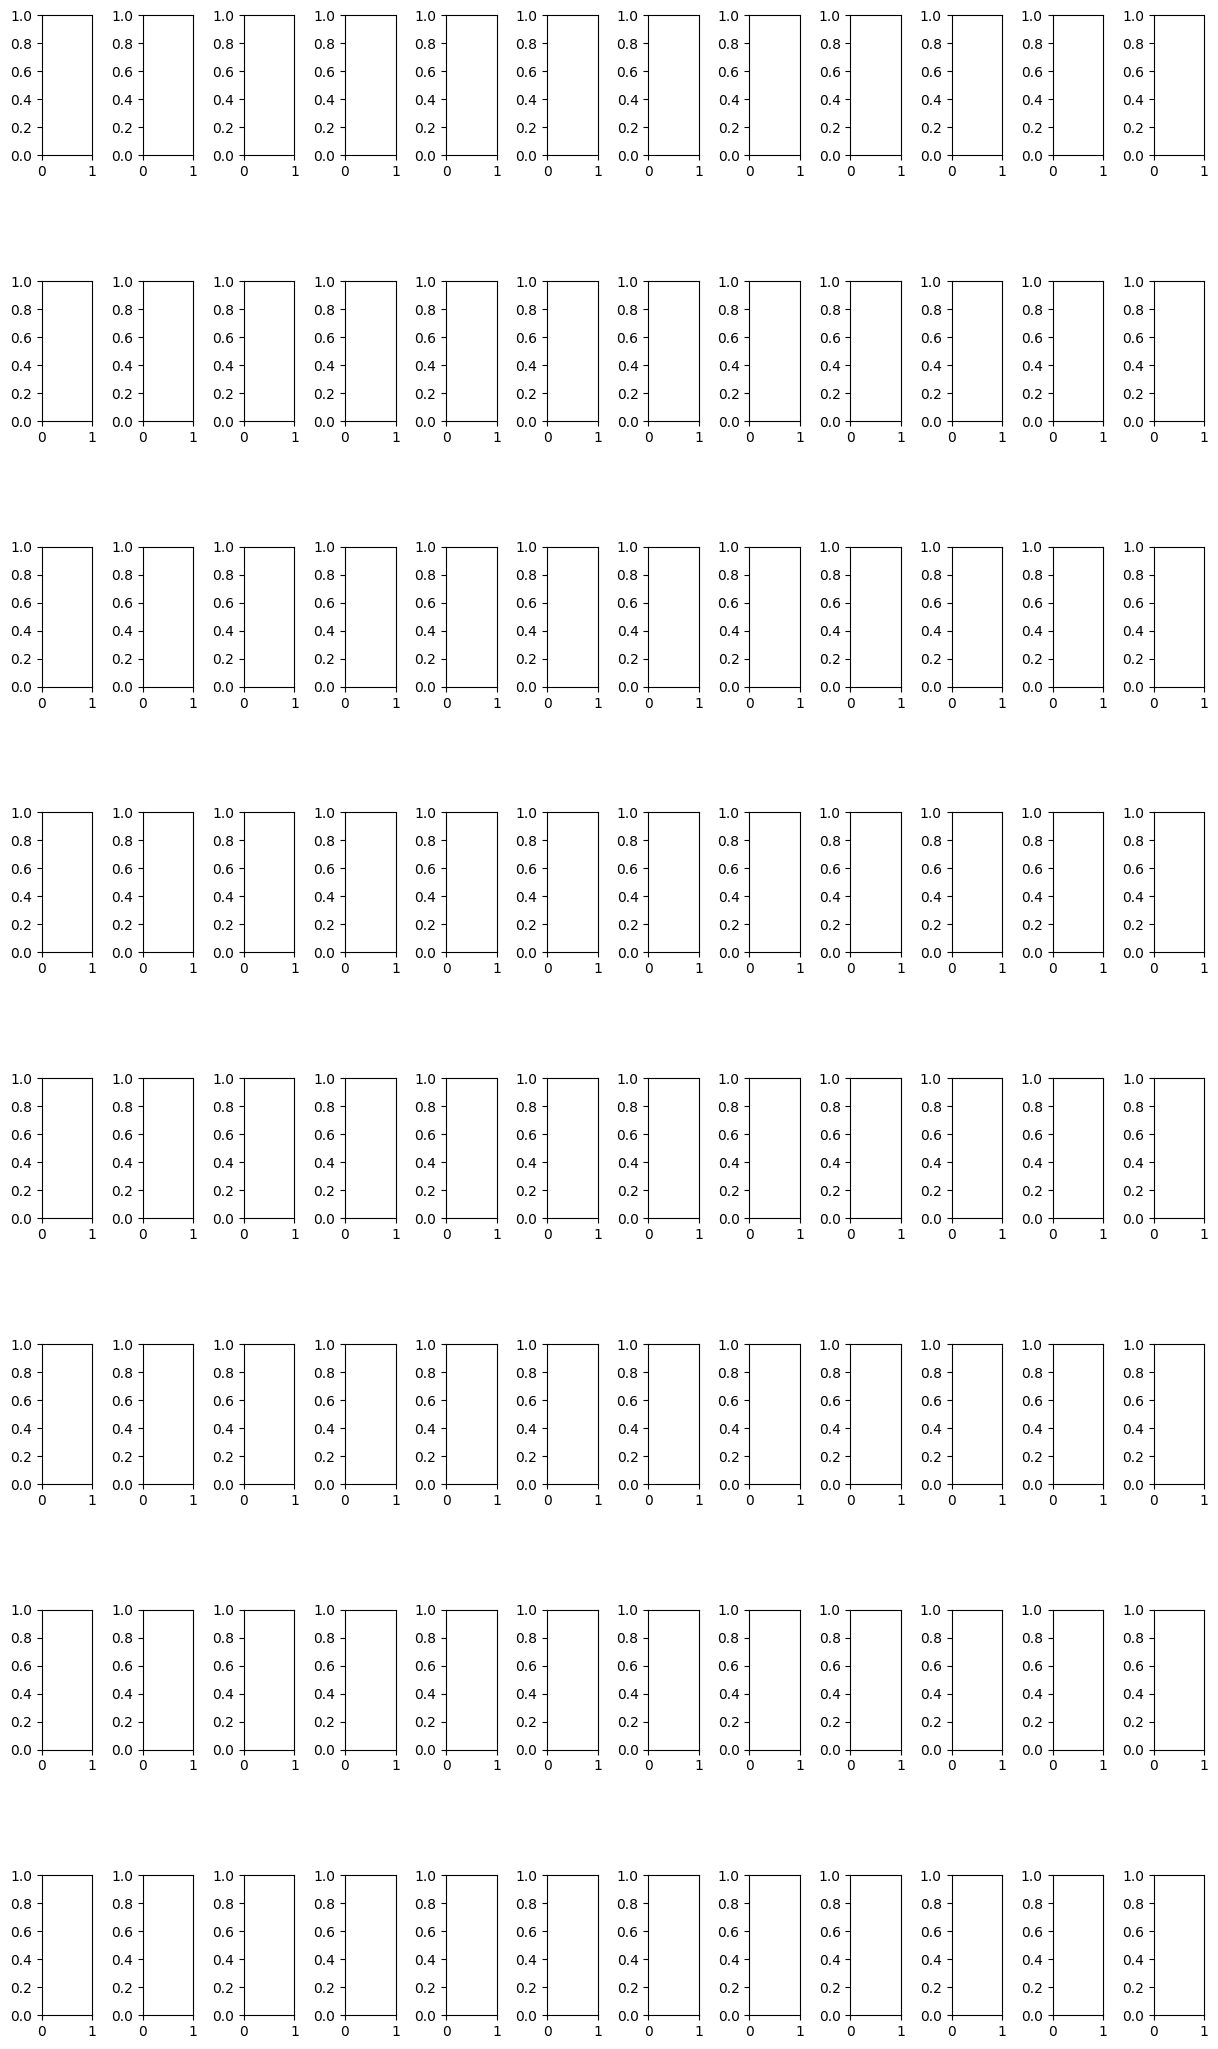

In [ ]:
ssi_list = []
psnr_list = []
energy_list = []

fig, axs = plt.subplots(rows, coll, figsize=(15, 5))  # 5 rows, 1 column
plt.subplots_adjust(left=0.125, bottom=6, right=0.9, top=10, wspace=1, hspace=0.9)

# loop throw all Bitpositions 
for indexBit, approxBit in enumerate(bit_list):
    # loop throw all Algorithm
    for indexAlgo, approxAlgo in enumerate(algo_list):
        # show picture in subplot
        axs[indexBit].imshow(add_approx_list[indexBit], cmap = "gray")
        # Add an annotation to the subplot
        axs[indexBit].annotate(f"\nTotal Energy consumed: \n{round(total_energy_lsit[indexBit],0)} pJ \nor {round(total_energy_lsit[indexBit]/10**6,2)} uJ", (0,0), (0,-5),xycoords='axes fraction', textcoords='offset points', va='top')
       
        if indexBit == 0:
            axs[indexBit].set_title(f"exact")
        else:
            axs[indexBit].set_title(f"{approxAlgo} Bit {approxBit}")
        try:
            data_range = add_approx_list[0].max() - add_approx_list[indexBit].max()  
            mse = np.mean((add_approx_list[0] - add_approx_list[indexBit])**2)     
             # load results to dictionary
            loaded_dict[approxAlgo]["ssi"][indexBit] = round(ssim(add_approx_list[0], add_approx_list[-1], data_range=data_range),2)
            loaded_dict[approxAlgo]["psnr"][indexBit] = round(10 * log10((add_approx_list[0].max()**2) /mse),2)
            loaded_dict[approxAlgo]["energy_con"][indexBit] = round(total_energy/10**9,2)
            
        except Exception as e:
            print(f'Error plot at: indexBit {indexBit} {e}')
# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]

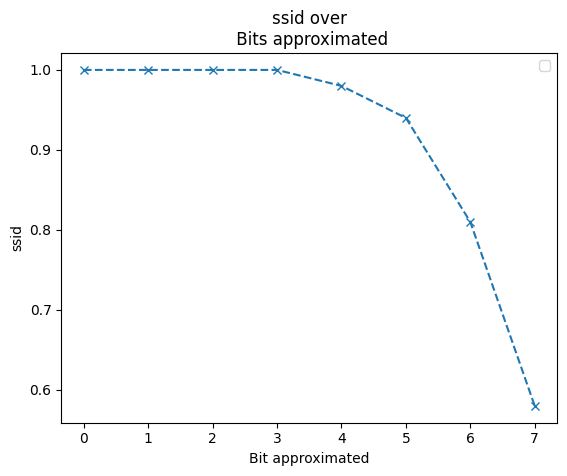

In [ ]:
# plot ssid over approximation of different amount of Bits and algorithms
for indexalgo, algo in enumerate(algo_list):
    plt.plot(ssi_list,"x--",  label=algo)
    plt.title(f"ssid over\n Bits approximated")
    plt.xlabel("Bit approximated")
    plt.ylabel("ssid")

plt.legend()
plt.plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]

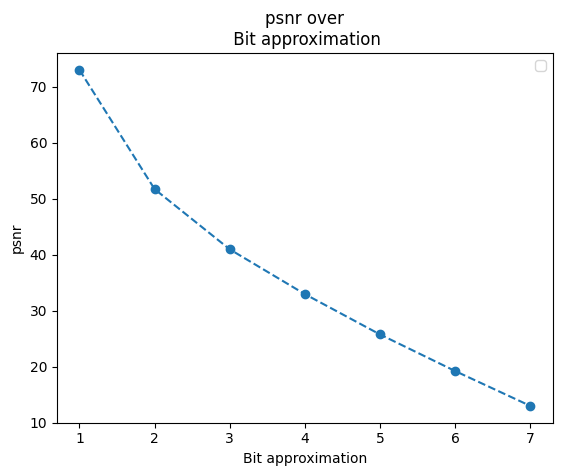

In [ ]:
# peak signal to noice ratio over different amount of Bits and algorithms
for indexalgo, algo in enumerate(algo_list):
    plt.plot(psnr_list,"o--",  label=algo)
    plt.title(f"psnr over\n Bit approximation")
    plt.xlabel("Bit approximation")
    plt.ylabel("psnr")


plt.legend()
plt.plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]

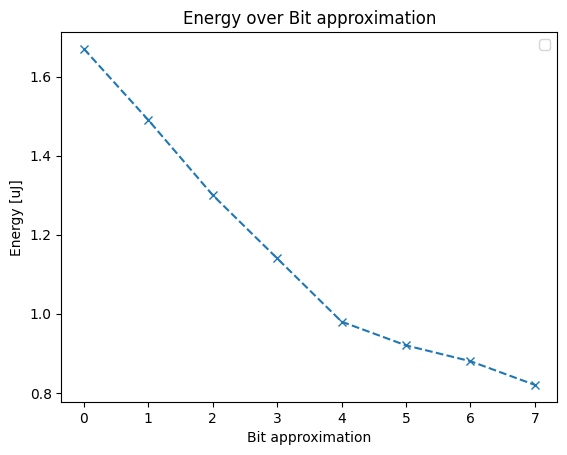

In [ ]:
# energy consumption over different amount of Bits and algorithms
for indexalgo, algo in enumerate(algo_list):
    plt.plot(loaded_dict[algo]["energy_con"],"x--",  label=algo)
    plt.title(f"Energy over Bit approximation")
    plt.xlabel("Bit approximation")
    plt.ylabel("Energy [mJ]")

plt.legend()
plt.plot()